In [1]:
import strawberryfields as sf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import h5py
from datetime import datetime
import seaborn as sns
from utility import *

In the utility.py, we define four functions of different sensing schemes:

#### OneModeCoherentHO(Ns,t,nth,shots): performs sensing using a single coherent state and performing homodyne measurements.

#### OneModeCoherentHD(Ns,t,nth,shots): performs sensing using a single coherent state and performing heterodyne measurements.

#### TwoModeSqueezedHD(Ns,t,nth,shots): performs sensing using two-mode squeezing and performing heterodyne measurements.

#### TwoModeThermalHD(Ns,t,nth,shots): performs sensing using two-mode thermal states that are classically correlated and performing heterodyne measurements

"""
Args:
    
Ns (float) : Average number of photons in the #1 mode

t,nth (float,float) : channel transmittivity and number of thermal photons for the thermal loss channel

shots (integer) : number of repeated iid measurements to perform

"""

### Problem definition

To extract information about about a sample, we can shine light on it and extract relevant information from the reflected signal.

Quantum sensing relies on the use of quantum resources in the light samples and/or at the detection stage to improve the detection sensitivity. 

The sensing problem that we are tackling here is rather simple: being able to distinguish between having a reflecting sample present, or not. This is a binary outcome problem that with two hypothesis to test. 

Here we focus on using Gaussian states of light, Gaussian operations and field-quadrature measurements. 
The overarching goal is properly benchmark different classical and quantum sensing protocols, namely:

    Classical schemes:  1) Coherent state + homodyne detection
                        2) Coherent state + heterodyne detection
                        3) Correlated thermal states + heterodyne detection 
                        4) Two-mode Squeezed states + heterodyne detection

This problem can be tackled using Xanadu's Strawberryfields librairies, and in this code we aim at simulating measurement records and extract the relevant measurement statistics.

Indeed, the problem can be mapped simply into a 'prepare', 'interrogate target' and 'measure' problem, all involving simple Gaussian states and operations.


Target absent : H = 0 s1 is completely lost and totally replaced by atmospheric noise. Channel transmittivity t =0

Target present : H =1 s1 is reflected with probability r = 1 - t, where t is the channel transmittivity

Since the problem is all gaussian, the 'gaussian' backend can directly provide the first and second moments of the states. However, it is not compatible with heterodyne measurements and it doesn't provide a numerical simulation of the measurement statistics.

Hence, we resort to the Bosonic backend to do brute force statistics.

The end result is somewhat inconclusive as the simulations present significant fluctuations during the runs. Further investigation is required, but most probably the nature of the problem is at fault here given the low transmit powers and high channel loss and noise.

Overall setup configuration of the sample under test.

The sample is modeled as a ThermalLossChannel where the transmittivity is related to the sample reflectivity, while the thermal number of photons present relate to the temperature of the atmosphere. At microwave frequencies, nth ~ 1000 at 5GHz.

In [4]:
#Transmit power parameters
Ns = 10

#Loss Channel parameters
nth=1000
t=0.0001

# Number of measurements
shots=10000

np.random.seed(42)

### 1. Coherent state + Homodyne detection

In [724]:
#Target Absent 
s10 = np.zeros(shots)

s10 = OneModeCoherentHO(Ns,0,nth,shots)
M0=s10

# Target Present
s11 = np.zeros(shots)
s11 = OneModeCoherentHO(Ns,t,nth/np.sqrt(1-t),shots)
M1=s11

SNR_CHO=SNR(M0,M1)

In [725]:
print(SNR_CHO)

0.8024701742978395


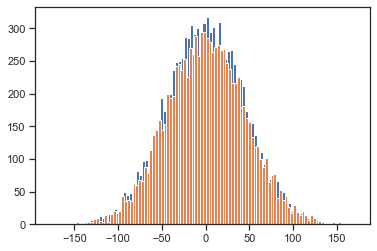

In [726]:
plt.hist(M0,bins=100);
plt.hist(M1,bins=100);
plt.show()

### 2. Coherent state + Heterodyne detection

In [727]:
#Target Absent 
s10 = np.zeros(shots)
s10 = OneModeCoherentHD(Ns,0,nth,shots)

# Target Present
s11 = np.zeros(shots)
s11 = OneModeCoherentHD(Ns,t,nth/np.sqrt(1-t),shots)

M0=s10.real*s10.real + s10.imag*s10.imag
M1=s11.real*s11.real + s11.imag*s11.imag

SNR_CHD=SNR(M0,M1)

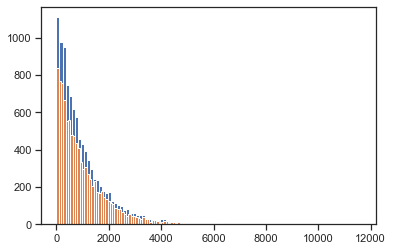

In [728]:
plt.hist(M0,bins=100);
plt.hist(M1,bins=100);
plt.show()

In [729]:
print(SNR_CHD)

0.3364100310419132


### 3. Two-mode Thermal states (classically correlated) + Heterodyne detection

In [730]:
#Target Absent 
s10 = (1+1j)*np.zeros(shots)
s20 = (1+1j)*np.zeros(shots)

s10,s20 = TwoModeThermalHD(Ns,0,nth,shots)
M0=s10.real*s20.real + s10.imag*s20.imag

# Target Present
s11 = (1+1j)*np.zeros(shots)
s21 = (1+1j)*np.zeros(shots)

s11,s21 = TwoModeThermalHD(Ns,t,nth/np.sqrt(1-t),shots)

M1=s11.real*s21.real + s11.imag*s21.imag

SNR_2TH = SNR(M0,M1)

In [731]:
print(SNR_2TH)

4.6189223712277725


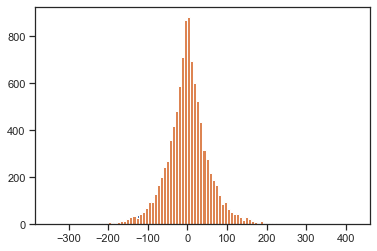

In [732]:
plt.hist(M0,bins=100);
plt.hist(M1,bins=100);
plt.show()

### 4. Two-mode squeezed states + heterodyne detection

The real quantum hardware "X8" chip provided on Strawberry Fields backend is not supporting heterodyne detection, so we use the bosonic sampling simulator to test this quantum case.

In [737]:
#Target Absent 
M0 = np.zeros(shots)
s10 = (1+1j)*np.zeros(shots)
s20 = (1+1j)*np.zeros(shots)

s10,s20 = TwoModeSqueezedHD(Ns,0,nth,shots)
M0=s10.real*s20.real - s10.imag*s20.imag

# Target Present
M1 = np.zeros(shots)
s11 = (1+1j)*np.zeros(shots)
s21 = (1+1j)*np.zeros(shots)


s11,s21 = TwoModeSqueezedHD(Ns,t,nth/np.sqrt(1-t),shots)
M1=s11.real*s21.real - s11.imag*s21.imag

SNR_2SQ = SNR(M0,M1)

In [738]:
print(SNR_2SQ)

0.3896304715272131


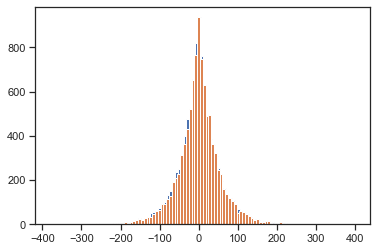

In [739]:
plt.hist(M0.real,bins=100);
plt.hist(M1.real,bins=100);
plt.show()

### Study SNR vs T

In [35]:
def SNR_batched_TwoModeThermalHD(Ns,t,nth,shots, batch_size):
    
    """
    Function that performs sensing using two-mode thermal states that are classically correlated and performing heterodyne measurements
    
    Args:
    
        Ns  (float) : Average number of photons in the #1 mode
        t   (float, 0 < t <= 1) : nonzero channel transmittivity while a target present and number of thermal photons for the thermal loss channel
        nth (float) : number of thermal photons for the thermal loss channel

        shots (integer) : number of repeated iid measurements to perform
        batch_size (integer):
    Returns:
        returns 
        
        s10, s20, s11, s21 (complex numpy array): the complex signal <X>+i<P> of both modes without or with the target
        SNR_batched (complex numpy array): the signal noise ratio taken at all the batches 
    
    
    """
    
    s10 = (1+1j)*np.zeros(shots)
    s20 = (1+1j)*np.zeros(shots)
    s11 = (1+1j)*np.zeros(shots)
    s21 = (1+1j)*np.zeros(shots)
    
    M0_batch=np.zeros(batch_size)
    M1_batch=np.zeros(batch_size)
    
    SNR_batched=np.zeros(int(shots/batch_size))
    
    if t<=0 or t>1:
        raise ValueError("t needs to be in the interval of (0,1]. ")    
    
    ind=0
    for i in range(shots):
        
        ##program without a target t=0
        prog0= sf.Program(2)
        
        with prog0.context as q:
        
            sf.ops.Thermal(Ns) | q[0] # State preparation
            sf.ops.BSgate() | (q[0],q[1])
            
            sf.ops.ThermalLossChannel(0,nth) | q[0] # Thermal loss channel mimicing target
     
            sf.ops.MeasureHD | q[0] # Het. Msmnt of signal 1
            sf.ops.MeasureHD | q[1] # Het. Msmnt of signal 2

        # Need to run twice because of bug in the bosonic backend in dealing with repeated HD measurements
    
        eng0 = sf.Engine("bosonic")
        results0 = eng0.run(prog0)
        eng0 = sf.Engine("bosonic")
        results0 = eng0.run(prog0)
    
        #Collecting the samples
        samples0 = results0.all_samples
    
        #Creating the measurement records
        s10[i] = samples0[0][0]
        s20[i] = samples0[1][0]
 

        ##program with a target t>0

        prog1= sf.Program(2)
        
        with prog1.context as q:
        
            sf.ops.Thermal(Ns) | q[0] # State preparation
            sf.ops.BSgate() | (q[0],q[1])
            
            sf.ops.ThermalLossChannel(t,nth) | q[0] # Thermal loss channel mimicing target
     
            sf.ops.MeasureHD | q[0] # Het. Msmnt of signal 1
            sf.ops.MeasureHD | q[1] # Het. Msmnt of signal 2

        # Need to run twice because of bug in the bosonic backend in dealing with repeated HD measurements
    
        eng1 = sf.Engine("bosonic")
        results1 = eng1.run(prog1)
        eng1 = sf.Engine("bosonic")
        results1 = eng1.run(prog1)
        
        #Collecting the samples
        samples1 = results1.all_samples
    
        #Creating the measurement records
        s11[i] = samples1[0][0]
        s21[i] = samples1[1][0]
        
        
        # perform SNR calculation for every batch size of shots
        M0_batch[i%batch_size]=s10[i].real*s20[i].real - s10[i].imag*s20[i].imag
        M1_batch[i%batch_size]=s11[i].real*s21[i].real - s11[i].imag*s21[i].imag

        if i%batch_size==0 and i>0:
            SNR_batched[ind]=SNR(M0_batch,M1_batch)
            M0_batch=np.zeros(batch_size)
            M1_batch=np.zeros(batch_size)    
            ind+=1
    # Interation over number of shots is done, outputing the records
    
    return s10, s20, s11, s21, SNR_batched

In [36]:
#Transmit power parameters
Ns = 10

#Loss Channel parameters
nth=1000
t=0.1

# Number of measurements
shots=10000

Repeat the batched SNR measurement 5 times and check how the SNR distributes over the shots.

In [37]:
s10, s20, s11, s21, SNR_batched1 = SNR_batched_TwoModeThermalHD(Ns,t,nth,shots, 100)
M0_1=s10.real*s20.real - s10.imag*s20.imag
M1_1=s11.real*s21.real - s11.imag*s21.imag

s10, s20, s11, s21, SNR_batched2 = SNR_batched_TwoModeThermalHD(Ns,t,nth,shots, 100)
M0_2=s10.real*s20.real - s10.imag*s20.imag
M1_2=s11.real*s21.real - s11.imag*s21.imag
s10, s20, s11, s21, SNR_batched3 = SNR_batched_TwoModeThermalHD(Ns,t,nth,shots, 100)
M0_3=s10.real*s20.real - s10.imag*s20.imag
M1_3=s11.real*s21.real - s11.imag*s21.imag
s10, s20, s11, s21, SNR_batched4 = SNR_batched_TwoModeThermalHD(Ns,t,nth,shots, 100)
M0_4=s10.real*s20.real - s10.imag*s20.imag
M1_4=s11.real*s21.real - s11.imag*s21.imag
s10, s20, s11, s21, SNR_batched5 = SNR_batched_TwoModeThermalHD(Ns,t,nth,shots, 100)
M0_5=s10.real*s20.real - s10.imag*s20.imag
M1_5=s11.real*s21.real - s11.imag*s21.imag

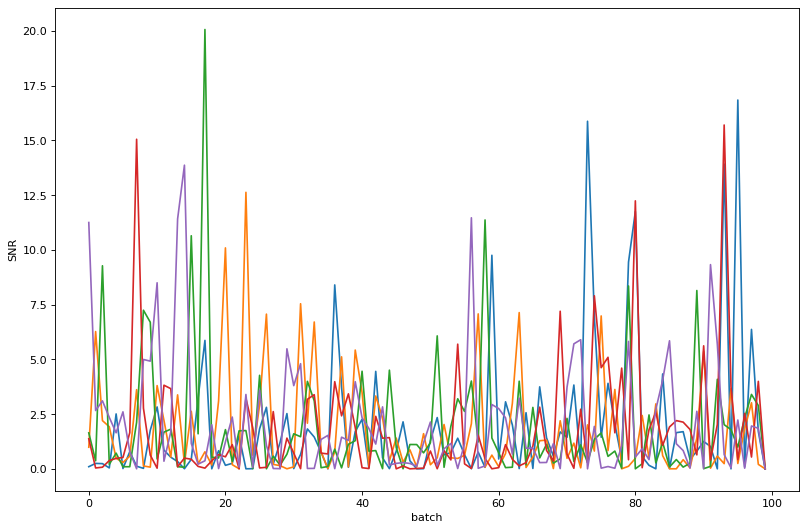

In [38]:
fig = plt.figure(figsize=(12, 8), dpi=80)
plt.plot(SNR_batched1)
plt.plot(SNR_batched2)
plt.plot(SNR_batched3)
plt.plot(SNR_batched4)
plt.plot(SNR_batched5)
plt.xlabel('batch')
plt.ylabel('SNR')
plt.show()

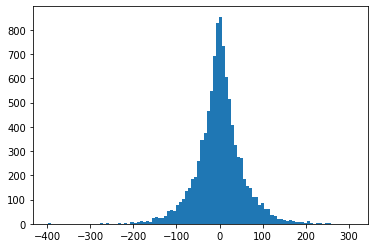

In [41]:
plt.figure()
plt.hist(M0_1,bins=100)
plt.show()

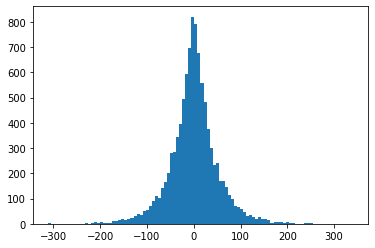

In [42]:
plt.figure()
plt.hist(M1_1,bins=100)
plt.show()

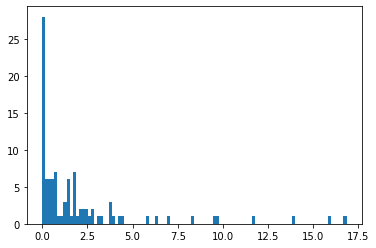

In [43]:
plt.figure()
plt.hist(SNR_batched1,bins=100)
plt.show()

### CHECKS

In [4]:
prog= sf.Program(6)

Ns=10

with prog.context as q:
    
    sf.ops.Thermal(Ns/2) | q[0] # State preparation
    sf.ops.Coherent(np.sqrt(Ns/4),0) | q[1]
    sf.ops.S2gate(np.arcsinh(np.sqrt(Ns/2)),0) | (q[2],q[3])
    sf.ops.Thermal(Ns) | q[4]
    sf.ops.BSgate() |(q[4],q[5])
    
eng = sf.Engine("gaussian")
result = eng.run(prog)
states=result.state

mu0,cov0 = states.reduced_gaussian([0])
mu1,cov1 = states.reduced_gaussian([1])
mu23,cov23 = states.reduced_gaussian([2,3])
mu45,cov45 = states.reduced_gaussian([4,5])

print(mu0,"\n",cov0,"\n")
print(mu1**2,"\n",cov1,"\n")
print(mu23,"\n",cov23,"\n")
print(mu45,"\n",cov45,"\n")

[0. 0.] 
 [[11.  0.]
 [ 0. 11.]] 

[10.  0.] 
 [[1. 0.]
 [0. 1.]] 

[0. 0. 0. 0.] 
 [[ 11.          10.95445115   0.           0.        ]
 [ 10.95445115  11.           0.           0.        ]
 [  0.           0.          11.         -10.95445115]
 [  0.           0.         -10.95445115  11.        ]] 

[0. 0. 0. 0.] 
 [[11. 10.  0.  0.]
 [10. 11.  0.  0.]
 [ 0.  0. 11. 10.]
 [ 0.  0. 10. 11.]] 



### Varying Ns and fix nth = 1000, t =0.1, shots= 4800, and save data into an hdf5 file

In [51]:
#Preparation parameters
Ns = np.logspace(-2, 2, num=20,endpoint=True)
Ns

array([1.00000000e-02, 1.62377674e-02, 2.63665090e-02, 4.28133240e-02,
       6.95192796e-02, 1.12883789e-01, 1.83298071e-01, 2.97635144e-01,
       4.83293024e-01, 7.84759970e-01, 1.27427499e+00, 2.06913808e+00,
       3.35981829e+00, 5.45559478e+00, 8.85866790e+00, 1.43844989e+01,
       2.33572147e+01, 3.79269019e+01, 6.15848211e+01, 1.00000000e+02])

In [52]:
#Loss Channel parameters
t= 0.1
nth=1000

# Number of measurements
shots=4800

In [46]:
timestamp = datetime.now().strftime("%m-%d-%y_%I_%M_%S_%p")
file_name = r"./data_test07-28-21_05_04_22_AM.hdf5" # r"./data_test" + timestamp + r".hdf5"
with h5py.File(file_name,'w') as f:
    g = f.create_group("varying_Ns_nth1000_t0.1_shots4800")
    
    g.create_dataset('Ns',data=Ns)  
    g.create_dataset('nth',data=nth)
    g.create_dataset('t',data=t)
    g.create_dataset('shots',data=shots)
    
    s10 = (1+1j)*np.zeros([len(Ns),shots])
    s20 = (1+1j)*np.zeros([len(Ns),shots])
    
    s11 = (1+1j)*np.zeros([len(Ns),shots])
    s21 = (1+1j)*np.zeros([len(Ns),shots])

    s10_dset=g.create_dataset('s10',data=s10)
    s20_dset=g.create_dataset('s20',data=s20)
    
    s11_dset=g.create_dataset('s11',data=s11)
    s21_dset=g.create_dataset('s21',data=s21)
    
    for i in range(len(Ns)):
        #Target Absent 
        s10[i,:],s20[i,:] = TwoModeSqueezedHD(Ns[i],0,nth,shots)
        s10_dset[i,:]=s10[i,:]
        s20_dset[i,:]=s20[i,:]
        # Target Present
        
        s11[i,:],s21[i,:] = TwoModeSqueezedHD(Ns[i],t,nth/np.sqrt(1-t),shots)
        s11_dset[i,:]=s11[i,:]
        s21_dset[i,:]=s21[i,:]

### Data reading block

In [47]:
with h5py.File("./data_test07-28-21_05_04_22_AM.hdf5","r")as f: # Copy the data file name here to read
    g=f['varying_Ns_nth1000_t0.1_shots4800']
    print(g.keys())
    Ns=np.array(g['Ns'])
    nth=np.array(g['nth'])
    t=np.array(g['t'])
    shots=np.array(g['shots'])

    print("Ns = ", Ns, "\n, nth = ", nth, ", t = ", t, ", shots = ", shots )

    s10=np.array(g['s10'])
    s20=np.array(g['s20'])

    s11=np.array(g['s11'])
    s21=np.array(g['s21'])

<KeysViewHDF5 ['Ns', 'nth', 's10', 's11', 's20', 's21', 'shots', 't']>
Ns =  [1.00000000e-02 1.62377674e-02 2.63665090e-02 4.28133240e-02
 6.95192796e-02 1.12883789e-01 1.83298071e-01 2.97635144e-01
 4.83293024e-01 7.84759970e-01 1.27427499e+00 2.06913808e+00
 3.35981829e+00 5.45559478e+00 8.85866790e+00 1.43844989e+01
 2.33572147e+01 3.79269019e+01 6.15848211e+01 1.00000000e+02] 
, nth =  1000 , t =  0.1 , shots =  4800


In [48]:
M0=np.empty(s10.shape, dtype="complex")
M1=np.empty(s20.shape, dtype="complex")
snr=np.empty(Ns.shape)
for i in range(len(Ns)):
    #M1[i,:] = s10[i,:]*s11[i,:]
    #M2[i,:] = s20[i,:]*s21[i,:]
    M0[i,:]=s10[i,:].real*s20[i,:].real - s10[i,:].imag*s20[i,:].imag

    M1[i,:]=s11[i,:].real*s21[i,:].real - s11[i,:].imag*s21[i,:].imag
    snr[i]=SNR(M0[i,:],M1[i,:])

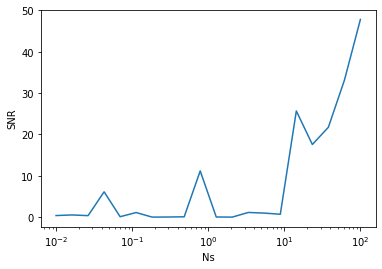

In [49]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

plt.plot(Ns,snr)
plt.xlabel('Ns')
plt.ylabel('SNR')
ax.set_xscale('log')

plt.show()

### SNR vs Ns for Case 1: Coherent States + Homodyne

In [55]:
timestamp = datetime.now().strftime("%m-%d-%y_%I_%M_%S_%p")
file_name = r"./data_test07-28-21_05_04_22_AM.hdf5" # r"./data_test" + timestamp + r".hdf5"
with h5py.File(file_name,'w') as f:
    g = f.create_group("varying_Ns_nth1000_t0.1_shots4800_case1_coherentHO")
    
    g.create_dataset('Ns',data=Ns)  
    g.create_dataset('nth',data=nth)
    g.create_dataset('t',data=t)
    g.create_dataset('shots',data=shots)
    
    s10 = np.zeros([len(Ns),shots])    
    s11 = np.zeros([len(Ns),shots])

    s10_dset=g.create_dataset('s10',data=s10)
    s11_dset=g.create_dataset('s11',data=s11)
    
    for i in range(len(Ns)):
        #Target Absent 
        s10_dset[i,:]=s10[i,:]
        s10[i,:] = OneModeCoherentHO(Ns[i],0,nth,shots)

    # Target Present
        s11[i,:] = OneModeCoherentHO(Ns[i],t,nth/np.sqrt(1-t),shots)
        s11_dset[i,:]=s11[i,:]


In [56]:
with h5py.File("./data_test07-28-21_05_04_22_AM.hdf5","r")as f: # Copy the data file name here to read
    g=f['varying_Ns_nth1000_t0.1_shots4800_case1_coherentHO']
    print(g.keys())
    Ns=np.array(g['Ns'])
    nth=np.array(g['nth'])
    t=np.array(g['t'])
    shots=np.array(g['shots'])

    print("Ns = ", Ns, "\n, nth = ", nth, ", t = ", t, ", shots = ", shots )

    s10=np.array(g['s10'])
    s11=np.array(g['s11'])
    

<KeysViewHDF5 ['Ns', 'nth', 's10', 's11', 'shots', 't']>
Ns =  [1.00000000e-02 1.62377674e-02 2.63665090e-02 4.28133240e-02
 6.95192796e-02 1.12883789e-01 1.83298071e-01 2.97635144e-01
 4.83293024e-01 7.84759970e-01 1.27427499e+00 2.06913808e+00
 3.35981829e+00 5.45559478e+00 8.85866790e+00 1.43844989e+01
 2.33572147e+01 3.79269019e+01 6.15848211e+01 1.00000000e+02] 
, nth =  1000 , t =  0.1 , shots =  4800


In [57]:
snr_CHO=np.empty(Ns.shape)
for i in range(len(Ns)):
    snr_CHO[i]=SNR(s10[i,:],s11[i,:])

### SNR vs Ns for Case 2: Coherent States + Heterodyne

In [64]:
timestamp = datetime.now().strftime("%m-%d-%y_%I_%M_%S_%p")
file_name = r"./data_test07-28-21_05_04_22_AM.hdf5" # r"./data_test" + timestamp + r".hdf5"
with h5py.File(file_name,'w') as f:
    g = f.create_group("varying_Ns_nth1000_t0.1_shots4800_case2_coherentHD")
    #g =f["varying_Ns_nth1000_t0.1_shots4800_case2_coherentHD"]
    g.create_dataset('Ns',data=Ns)  
    g.create_dataset('nth',data=nth)
    g.create_dataset('t',data=t)
    g.create_dataset('shots',data=shots)
    
    s10 = np.zeros([len(Ns),shots],dtype="complex")    
    s11 = np.zeros([len(Ns),shots],dtype="complex")

    s10_dset=g.create_dataset('s10',data=s10)
    s11_dset=g.create_dataset('s11',data=s11)
    
    for i in range(len(Ns)):
        #Target Absent 
        s10_dset[i,:]=s10[i,:]
        s10[i,:] = OneModeCoherentHD(Ns[i],0,nth,shots)

    # Target Present
        s11[i,:] = OneModeCoherentHD(Ns[i],t,nth/np.sqrt(1-t),shots)
        s11_dset[i,:]=s11[i,:]


In [65]:
with h5py.File("./data_test07-28-21_05_04_22_AM.hdf5","r")as f: # Copy the data file name here to read
    g=f["varying_Ns_nth1000_t0.1_shots4800_case2_coherentHD"]
    print(g.keys())
    Ns=np.array(g['Ns'])
    nth=np.array(g['nth'])
    t=np.array(g['t'])
    shots=np.array(g['shots'])

    print("Ns = ", Ns, "\n, nth = ", nth, ", t = ", t, ", shots = ", shots )

    s10=np.array(g['s10'])
    s11=np.array(g['s11'])
    

<KeysViewHDF5 ['Ns', 'nth', 's10', 's11', 'shots', 't']>
Ns =  [1.00000000e-02 1.62377674e-02 2.63665090e-02 4.28133240e-02
 6.95192796e-02 1.12883789e-01 1.83298071e-01 2.97635144e-01
 4.83293024e-01 7.84759970e-01 1.27427499e+00 2.06913808e+00
 3.35981829e+00 5.45559478e+00 8.85866790e+00 1.43844989e+01
 2.33572147e+01 3.79269019e+01 6.15848211e+01 1.00000000e+02] 
, nth =  1000 , t =  0.1 , shots =  4800


In [66]:
M0=np.empty(s10.shape, dtype="complex")
M1=np.empty(s10.shape, dtype="complex")
snr_CHD=np.empty(Ns.shape)
for i in range(len(Ns)):
    M0[i,:]=s10[i,:].real*s10[i,:].real + s10[i,:].imag*s10[i,:].imag
    M1[i,:]=s11[i,:].real*s11[i,:].real + s11[i,:].imag*s11[i,:].imag
    snr_CHD[i]=SNR(M0[i,:],M1[i,:])

### SNR vs Ns for Case 3: Two-mode Thermal states (classically correlated) + Heterodyne detection

In [70]:
timestamp = datetime.now().strftime("%m-%d-%y_%I_%M_%S_%p")
file_name = r"./data_test07-28-21_05_04_22_AM.hdf5" # r"./data_test" + timestamp + r".hdf5"
with h5py.File(file_name,'w') as f:
    g = f.create_group("varying_Ns_nth1000_t0.1_shots4800_case3_classicalHD")
    g.create_dataset('Ns',data=Ns)  
    g.create_dataset('nth',data=nth)
    g.create_dataset('t',data=t)
    g.create_dataset('shots',data=shots)
    
    s10 = (1+1j)*np.zeros([len(Ns),shots])
    s20 = (1+1j)*np.zeros([len(Ns),shots])
    
    s11 = (1+1j)*np.zeros([len(Ns),shots])
    s21 = (1+1j)*np.zeros([len(Ns),shots])

    s10_dset=g.create_dataset('s10',data=s10)
    s20_dset=g.create_dataset('s20',data=s20)
    
    s11_dset=g.create_dataset('s11',data=s11)
    s21_dset=g.create_dataset('s21',data=s21)
    
    for i in range(len(Ns)):
        #Target Absent 
        s10[i,:],s20[i,:] = TwoModeThermalHD(Ns[i],0,nth,shots)
        s10_dset[i,:]=s10[i,:]
        s20_dset[i,:]=s20[i,:]
        # Target Present
        
        s11[i,:],s21[i,:] = TwoModeThermalHD(Ns[i],t,nth/np.sqrt(1-t),shots)
        s11_dset[i,:]=s11[i,:]
        s21_dset[i,:]=s21[i,:]

In [71]:
with h5py.File("./data_test07-28-21_05_04_22_AM.hdf5","r")as f: # Copy the data file name here to read
    g=f["varying_Ns_nth1000_t0.1_shots4800_case3_classicalHD"]
    print(g.keys())
    Ns=np.array(g['Ns'])
    nth=np.array(g['nth'])
    t=np.array(g['t'])
    shots=np.array(g['shots'])

    print("Ns = ", Ns, "\n, nth = ", nth, ", t = ", t, ", shots = ", shots )

    s10=np.array(g['s10'])
    s20=np.array(g['s20'])

    s11=np.array(g['s11'])
    s21=np.array(g['s21'])

<KeysViewHDF5 ['Ns', 'nth', 's10', 's11', 's20', 's21', 'shots', 't']>
Ns =  [1.00000000e-02 1.62377674e-02 2.63665090e-02 4.28133240e-02
 6.95192796e-02 1.12883789e-01 1.83298071e-01 2.97635144e-01
 4.83293024e-01 7.84759970e-01 1.27427499e+00 2.06913808e+00
 3.35981829e+00 5.45559478e+00 8.85866790e+00 1.43844989e+01
 2.33572147e+01 3.79269019e+01 6.15848211e+01 1.00000000e+02] 
, nth =  1000 , t =  0.1 , shots =  4800


In [72]:
M0=np.empty(s10.shape, dtype="complex")
M1=np.empty(s20.shape, dtype="complex")
snr_2TH=np.empty(Ns.shape)
for i in range(len(Ns)):
    #M1[i,:] = s10[i,:]*s11[i,:]
    #M2[i,:] = s20[i,:]*s21[i,:]
    M0[i,:]=s10[i,:].real*s20[i,:].real + s10[i,:].imag*s20[i,:].imag

    M1[i,:]=s11[i,:].real*s21[i,:].real + s11[i,:].imag*s21[i,:].imag
    snr_2TH[i]=SNR(M0[i,:],M1[i,:])

### Compare the SNRs between two-mode squeezing states and coherent states.

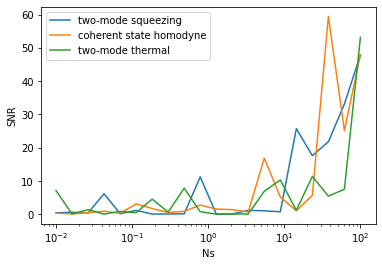

In [74]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

plt.plot(Ns,snr,label="two-mode squeezing")
plt.plot(Ns,snr_CHO, label="coherent state homodyne")
#plt.plot(Ns,snr_CHD)
plt.plot(Ns,snr_2TH, label="two-mode thermal")
plt.xlabel('Ns')
plt.ylabel('SNR')
plt.legend()
ax.set_xscale('log')

plt.show()